# H2o python API

In [29]:
import os
import h2o
%matplotlib inline
import pandas as pd                   
import matplotlib.pyplot as plt
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [3]:
h2o.init( nthreads = -1, max_mem_size = 5 )



No instance found at ip and port: localhost:54321. Trying to start local jar...


JVM stdout: /var/folders/vt/891vkg_56n92b5f3rr4980j80000gn/T/tmp4_n5uamf/h2o_ethen_started_from_python.out
JVM stderr: /var/folders/vt/891vkg_56n92b5f3rr4980j80000gn/T/tmpur90xka6/h2o_ethen_started_from_python.err
Using ice_root: /var/folders/vt/891vkg_56n92b5f3rr4980j80000gn/T/tmpor_v_s35


Java Version: java version "1.8.0_60"
Java(TM) SE Runtime Environment (build 1.8.0_60-b27)
Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)


Starting H2O JVM and connecting: ............. Connection successful!


/Users/ethen/anaconda/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/ethen/anaconda/lib/python3.5/site-packages/IPython/core/formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
/Users/ethen/anaconda/lib/python3.5/site-packages/IPython/core/formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
/Users/ethen/anaconda/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):
/Users/ethen/anaconda/lib/python3.5/site-packages/IPython/core

H2O cluster uptime:,1 seconds 348 milliseconds
H2O cluster version:,3.8.0.3
H2O cluster name:,H2O_started_from_python_ethen_aid549
H2O cluster total nodes:,1
H2O cluster total free memory:,4.44 GB
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321
H2O Connection proxy:,None


In [9]:
covtype_df = h2o.import_file( path = os.path.abspath("../covtype.full.csv") )


Parse Progress: [##################################################] 100%


In [18]:
# split the data 60 training, 20 validation, 20 test
train, valid, test = covtype_df.split_frame( [0.6, 0.2], seed = 1234 )

# prepare predictors and response columns
covtype_X = covtype_df.col_names[:-1]      
covtype_y = covtype_df.col_names[-1]
covtype_y

'Cover_Type'

In [17]:
# types of each column, h2o will automatically perform one-hot encoding
covtype_df.types

{'Aspect': 'int',
 'Cover_Type': 'enum',
 'Elevation': 'int',
 'Hillshade_3pm': 'int',
 'Hillshade_9am': 'int',
 'Hillshade_Noon': 'int',
 'Horizontal_Distance_To_Fire_Points': 'int',
 'Horizontal_Distance_To_Hydrology': 'int',
 'Horizontal_Distance_To_Roadways': 'int',
 'Slope': 'int',
 'Soil_Type': 'enum',
 'Vertical_Distance_To_Hydrology': 'int',
 'Wilderness_Area': 'enum'}

## Deep Learning 

walking through the [notebook](http://nbviewer.jupyter.org/github/h2oai/h2o-tutorials/blob/master/tutorials/deeplearning/deeplearning.ipynb).

In [19]:
covtype_model_v1 = H2ODeepLearningEstimator( 
    model_id = "covtype_v1", 
    epochs = 1, 
    variable_importances = True
)
covtype_model_v1.train( covtype_X, covtype_y, training_frame = train, validation_frame = valid )


deeplearning Model Build Progress: [##################################################] 100%


In [23]:
var_df = pd.DataFrame( 
    covtype_model_v1.varimp(), 
    columns = ["Variable", "Relative Importance", "Scaled Importance", "Percentage"] 
)
print(var_df.shape)
var_df.head(10)

(56, 4)


,Variable,Relative Importance,Scaled Importance,Percentage
0,Elevation,1.000000,1.000000,0.030648
1,Wilderness_Area.area_0,0.979928,0.979928,0.030033
2,Horizontal_Distance_To_Roadways,0.963858,0.963858,0.029540
3,Horizontal_Distance_To_Fire_Points,0.886730,0.886730,0.027177
4,Wilderness_Area.area_2,0.848711,0.848711,0.026011
5,Wilderness_Area.area_1,0.811592,0.811592,0.024874
6,Wilderness_Area.area_3,0.791894,0.791894,0.024270
7,Soil_Type.type_23,0.735948,0.735948,0.022555
8,Soil_Type.type_12,0.719147,0.719147,0.022041
9,Soil_Type.type_28,0.717092,0.717092,0.021978


Now we run another, smaller network and we let it stop automatically once the misclassification rate converges (specifically if the moving average of length 2 does not improve by at least 1% for 2 consecutive scoring events).

In [24]:
covtype_model_v2 = H2ODeepLearningEstimator(
    model_id = "covtype_v2", 
    hidden = [ 32, 32, 32],               # small network, runs faster
    epochs = 1000000,                  # hopefully converges earlier...
    score_validation_samples = 10000,  # sample the validation dataset (faster)
    stopping_rounds = 2,
    stopping_metric = "misclassification", # alternatives: "MSE","logloss","r2"
    stopping_tolerance = 0.01
)
covtype_model_v2.train( covtype_X, covtype_y, training_frame = train, validation_frame = valid )


deeplearning Model Build Progress: [##################################################] 100%


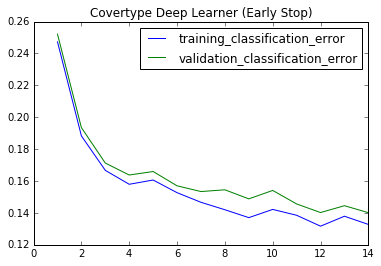

In [31]:
# we can visualize the scoring history
cov_v2_df = covtype_model_v2.scoring_history()
plt.plot( cov_v2_df['training_classification_error'], label = "training_classification_error" )
plt.plot( cov_v2_df['validation_classification_error'], label = "validation_classification_error" )
plt.title("Covertype Deep Learner (Early Stop)")
plt.legend()
plt.show()

We can see that the test set's number is fairly in line with our validation results from the graph.

In [33]:
pred = covtype_model_v2.predict(test).as_data_frame( use_pandas = True )
test_actual = test.as_data_frame( use_pandas = True )['Cover_Type']
( test_actual == pred['predict'] ).mean()

0.86421679786857963

## Ensemble Tree

walking through the [notebook](https://github.com/h2oai/h2o-tutorials/blob/master/tutorials/gbm-randomforest/GBM_RandomForest_Example.ipynb).

In [38]:
gbm_v3 = H2OGradientBoostingEstimator(
    ntrees = 30,
    learn_rate = 0.3,
    max_depth = 10,
    sample_rate = 0.7,
    col_sample_rate = 0.7,
    stopping_rounds = 2,
    stopping_tolerance = 0.01,
    score_each_iteration = True,
    model_id = "gbm_covType_v3",
    seed = 2000000
)
gbm_v3.train( covtype_X, covtype_y, training_frame = train, validation_frame = valid )


gbm Model Build Progress: [##################################################] 100%


In [39]:
rf_v2 = H2ORandomForestEstimator(
    model_id = "rf_covType_v2",
    ntrees = 200,
    max_depth = 30,
    stopping_rounds = 2,
    stopping_tolerance = 0.01,
    score_each_iteration = True,
    seed = 3000000)
rf_v2.train( covtype_X, covtype_y, training_frame = train, validation_frame = valid )


drf Model Build Progress: [##################################################] 100%


In [42]:
final_rf_predictions = rf_v2.predict(test)
( final_rf_predictions['predict'] == test['Cover_Type'] ).as_data_frame( use_pandas = True ).mean()

predict    0.953897
dtype: float64

Notes.

1. In a production setting where fine-grain accuracy is beneficial, it is common to set the learn rate to a very small number, such as 0.01 or smaller, and add trees to match. 
2. Use of early stopping is very powerful in allowing the setting of a low learning rate and the building as many trees as needed until the desired convergence is met.

## Grid Search 

1. [python booklet](http://h2o-release.s3.amazonaws.com/h2o/master/3378/docs-website/h2o-docs/booklets/Python_booklet.pdf).
2. [Getting information about the grid search model workflow](https://github.com/h2oai/h2o-3/blob/master/h2o-docs/src/product/tutorials/GridSearch.md#random-hyper-parmameter-grid-search-example).

In [95]:
ntrees_opt = [ 5, 15 ]
max_depth_opt = [2, 4]
learn_rate_opt = [0.1,0.2]
hyper_parameters = {
    "ntrees": ntrees_opt, 
    "max_depth": max_depth_opt,
    "learn_rate": learn_rate_opt
}
# you can pass in additional search_criteria for random search; e.g.
# search_criteria = { 'strategy': 'RandomDiscrete', 'max_models': 3 }
gs = H2OGridSearch( 
    model = H2OGradientBoostingEstimator( distribution = "multinomial" ), 
    hyper_params = hyper_parameters,
    grid_id = "grid1"
)

In [59]:
gs.train( x = covtype_X, y = covtype_y, training_frame = train, validation_frame = valid )


gbm Grid Build Progress: [##################################################] 100%


Sort the models in the grid space by a metric , 'mse', 'r2', 'logloss'; obtain the model id of the model with the best score.

In [80]:
best_model_id = gs.sort_by( metric = "logloss", increasing = True )['Model Id'][0]
best_model = h2o.get_model(best_model_id)
best_model.predict(train)

predict,class_1,class_2,class_3,class_4,class_5,class_6,class_7
class_1,0.75132,0.21922,0.00587509,0.00505035,0.00575674,0.00586757,0.00691034
class_1,0.827656,0.127404,0.00594402,0.00506221,0.0059703,0.00593174,0.0220315
class_1,0.884232,0.091247,0.0050751,0.00435566,0.00504936,0.00507264,0.00496839
class_2,0.0305834,0.929408,0.0069238,0.00529501,0.0114211,0.0100011,0.00636765
class_1,0.876184,0.0838305,0.0053489,0.00459064,0.00532177,0.00534631,0.0193781
class_2,0.137774,0.820198,0.00634637,0.00545548,0.017187,0.00633824,0.00670102
class_1,0.867821,0.0943964,0.00534922,0.00459092,0.00532209,0.00534663,0.017174
class_2,0.178554,0.753593,0.00717514,0.00611425,0.0398143,0.00785674,0.00689261
class_2,0.429951,0.51107,0.00948697,0.00818268,0.0191852,0.0127544,0.00937016
class_2,0.104472,0.821414,0.00616151,0.00532503,0.0501017,0.00622306,0.0063027


In [94]:
# best_model.model_performance().confusion_matrix()

In [82]:
gs.get_hyperparams(best_model_id)

Hyperparameters: [ntrees, max_depth, learn_rate]


[15, 4, 0.2]